<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/simpleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Toy GAN in PyTorch
By
Fayyaz Minhas

Let's have a very simple process that generates coin flips with a probability of 0.3 of producing heads. We would like to use a Generative Adversarial Network (GAN) to model this process using a number of data samples for training. 

Using a GAN is an overkill for this simple task but it will help you understand how GANs can model complex densities implicitly and can be used to generate samples that mimic the true or natural generative process. 

We first simulate the coin toss and generate 1024 training samples below. The histogram shows the (sample estimate of) the true density. 

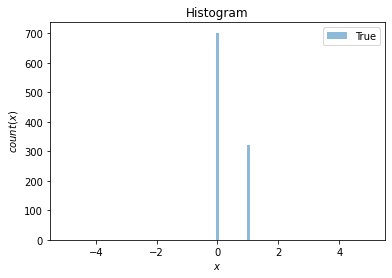

Example Data tensor([[0., 0., 1.,  ..., 1., 0., 0.]])


In [ ]:
"""
A toy GAN to generate coin tosses
"""

# Let's model the natural density and generate some data using that

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
train_data_length = 1024
def cointoss(t):
  phead = 0.3
  return 1.0*(t<phead)

train_data = torch.zeros((train_data_length, 1))
train_data[:, 0] = cointoss(torch.rand(train_data_length))
bins = np.linspace(-5, 5, 100)
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.show()
print('Example Data',train_data.T)

Below, we make a generator and a discriminator and train them with a batch size of 32. The generator will produce coin toss results which should have the same probabilities as the original coin and it will learn its weight parameters based on the observations only and its interaction with the discriminator. The generator takes a Gaussian random noise prior as input, i.e., its input is a single Gaussian Random number with mean zero and variance 1.0. It will learn to map this input number to the target variable (heads or tails) by learning the sampling based on given observations. Consequently, our generator is a single input, single output neural network. 

The discriminator will take a random number as input and decide whether it is fake (generated by the Generator) or real (generated by the real process) by learning to produce an output of 0.0 for fake and a label of 1.0 for real samples. 

We use binary cross entropy as the loss function in this case. At each training step the discriminator learns to classify real and fake data samples whereas the generator tries to produce samples that match the natural process. For visualization, we plot the current estimate of the histogram after 50 epochs and compare it to the true density. 

Epoch: 0 Loss D.: 0.6740565299987793
Epoch: 0 Loss G.: 0.7906392812728882


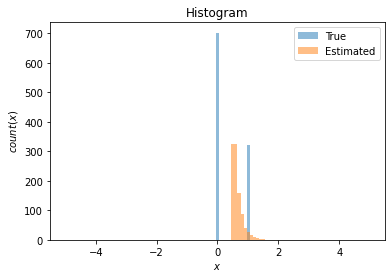

Epoch: 50 Loss D.: 0.6975748538970947
Epoch: 50 Loss G.: 0.8733211159706116


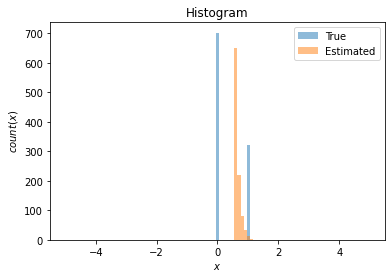

Epoch: 100 Loss D.: 0.7035763263702393
Epoch: 100 Loss G.: 0.6048833727836609


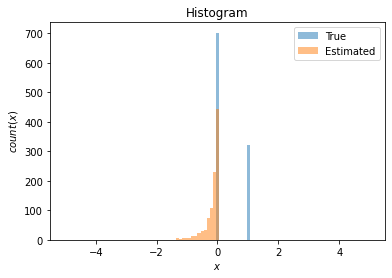

Epoch: 150 Loss D.: 0.6285879611968994
Epoch: 150 Loss G.: 0.8928716778755188


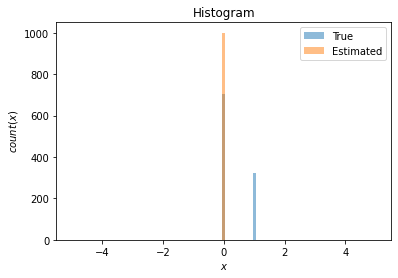

Epoch: 200 Loss D.: 0.530340313911438
Epoch: 200 Loss G.: 0.8956529498100281


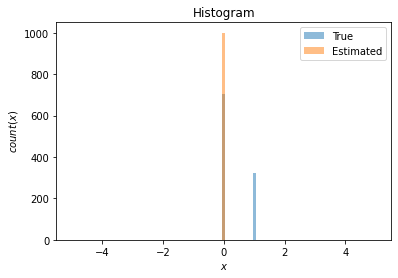

Epoch: 250 Loss D.: 0.6818928718566895
Epoch: 250 Loss G.: 0.7176185846328735


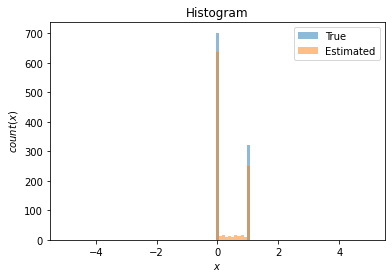

Epoch: 300 Loss D.: 0.6867138743400574
Epoch: 300 Loss G.: 0.6894106268882751


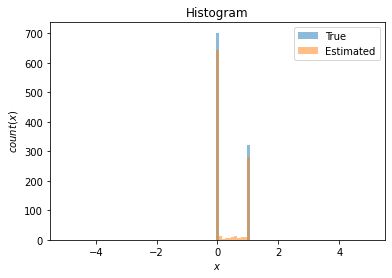

Epoch: 350 Loss D.: 0.6848896145820618
Epoch: 350 Loss G.: 0.747254490852356


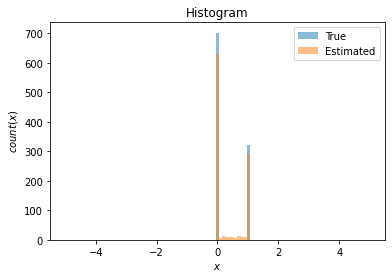

Epoch: 400 Loss D.: 0.689879834651947
Epoch: 400 Loss G.: 0.7748250365257263


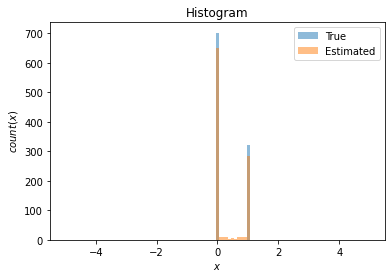

Epoch: 450 Loss D.: 0.6744623184204102
Epoch: 450 Loss G.: 0.7256012558937073


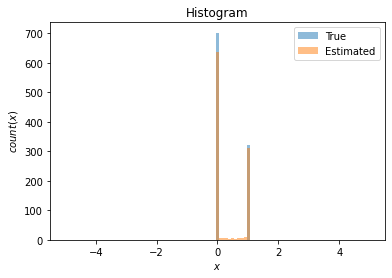

In [ ]:
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

# Discriminator classifies a given input into real (0) or fake (1)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),            
            nn.Linear(32, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()


#Generator generates a sample using latent random noise factors as input
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for descriminator training
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 1))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Discriminator training
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for generator training
        latent_space_samples = torch.randn((batch_size, 1))

        # Generator training
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        

        # Output value of loss function
        if epoch % 50 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            latent_space_samples = torch.randn(1000, 1)
            generated_samples = generator(latent_space_samples)
            latent_space_samples = torch.randn(1000, 1).detach()
            generated_samples = generated_samples.detach()
            plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
            plt.hist(generated_samples[:,0],bins=bins,alpha=0.5, label='Estimated')
            plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
            plt.show()
           



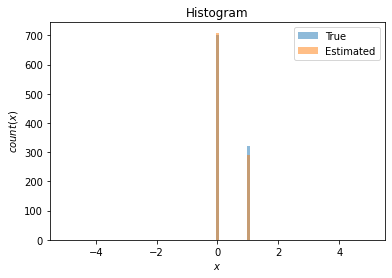

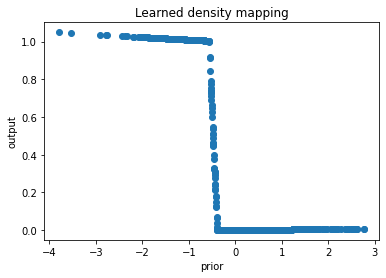

Generated Samples tensor([[1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.]])


In [ ]:
plt.figure()
latent_space_samples = torch.randn(1000, 1)
generated_samples = generator(latent_space_samples)
latent_space_samples = latent_space_samples.detach()
generated_samples = generated_samples.detach()
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.hist(np.round(generated_samples[:,0]),bins=bins,alpha=0.5, label='Estimated')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.figure()
plt.plot(latent_space_samples,generated_samples[:,0],'o')
plt.xlabel('prior');plt.ylabel('output');plt.title('Learned density mapping')
plt.show()
print('Generated Samples',torch.round(generated_samples[:50].T))

## Exercise:

See if you can train a model with a diffenrent probability of heads.

See if you can train a GAN to model more complex 1-D density estimation problems. 

See if you can change the loss function and architectures of the generator and discriminator networks to learn the desnsity more efficiently.



### Acknowledgements

Some parts of this tutorial have been inspired from the source below which is strongly recommended for reading.

Raevskiy, Mikhail. “Write Your First Generative Adversarial Network Model on PyTorch.” Medium, August 31, 2020. https://medium.com/dev-genius/write-your-first-generative-adversarial-network-model-on-pytorch-7dc0c7c892c7.
